In [ ]:
%pip install jmetalpy
%pip install scikit-posthocs

     |████████████████████████████████| 112kB 5.3MB/s 
  Created wheel for jmetalpy: filename=jmetalpy-1.5.5-cp36-none-any.whl size=196213 sha256=bc6481620620811155f2fbeacc704ac0e1d52c12c051258c784d2fa306510299
  Stored in directory: /root/.cache/pip/wheels/d0/ae/f5/6493b2f72d1311cf8f97e283039fb225f4743879bd04345a9e
Successfully built jmetalpy


In [ ]:
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.operator import BinaryTournamentSelection, PolynomialMutation, SBXCrossover, UniformMutation
from jmetal.problem.singleobjective.unconstrained import Rastrigin
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.core.observer import Observer
import logging
import matplotlib.pyplot as plt 
import scikit_posthocs as sp
from scipy import stats
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
import numpy as np
from scipy import stats


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
class DataObserver(Observer):

    def __init__(self, frequency: float = 1.0, data = []) -> None:
        """ Show the number of evaluations, best fitness and computing time.
        :param frequency: Display frequency. """
        self.display_frequency = frequency
        self.data = data

    def update(self, *args, **kwargs):
        computing_time = kwargs['COMPUTING_TIME']
        evaluations = kwargs['EVALUATIONS']
        solutions = kwargs['SOLUTIONS']

        if (evaluations % self.display_frequency) == 0 and solutions:
            if type(solutions) == list:
                fitness = solutions[0].objectives
            else:
                fitness = solutions.objectives
            self.data.append(fitness[0])

In [ ]:
from copy import copy
from typing import TypeVar, List

from jmetal.core.algorithm import EvolutionaryAlgorithm
from jmetal.core.operator import Mutation
from jmetal.core.problem import Problem
from jmetal.util.evaluator import Evaluator, SequentialEvaluator
from jmetal.util.generator import Generator, RandomGenerator
from jmetal.util.termination_criterion import TerminationCriterion
from jmetal.util.constraint_handling import overall_constraint_violation_degree

S = TypeVar('S')
R = TypeVar('R')


class CloneAlg(EvolutionaryAlgorithm[S, R]):

    def __init__(self,
                 problem: Problem,
                 population_size: int,
                 offspring_population_size: int,
                 mutation: Mutation,
                 termination_criterion: TerminationCriterion,
                 population_generator: Generator = RandomGenerator(),
                 population_evaluator: Evaluator = SequentialEvaluator()):
        super(CloneAlg, self).__init__(
            problem=problem,
            population_size=population_size,
            offspring_population_size=offspring_population_size)
        self.population_size = population_size
        self.offspring_population_size = offspring_population_size

        self.mutation_operator = mutation

        self.population_generator = population_generator
        self.population_evaluator = population_evaluator

        self.termination_criterion = termination_criterion
        self.observable.register(termination_criterion)

    def create_initial_solutions(self) -> List[S]:
        return [self.population_generator.new(self.problem)
                for _ in range(self.population_size)]

    def evaluate(self, solution_list: List[S]):
        return self.population_evaluator.evaluate(solution_list, self.problem)

    def stopping_condition_is_met(self) -> bool:
        return self.termination_criterion.is_met

    def step(self):
        mating_population = self.selection(self.solutions)
        offspring_population = self.reproduction(mating_population)
        offspring_population = self.evaluate(offspring_population)

        self.solutions = self.replacement(self.solutions, offspring_population)

    def selection(self, population: List[S]) -> List[S]:
        return population

    def reproduction(self, population: List[S]) -> List[S]:
        offspring_population = []
        overall_fitness = np.mean([solution.objectives[0] for solution in population])
        for solution in population:
            fitness = solution.objectives[0]
            for j in range(int(self.offspring_population_size * 0.1 * (fitness / overall_fitness))): # make clones based on fitness - it could be applied better
                new_solution = copy(solution)
                offspring_population.append(self.mutation_operator.execute(new_solution)) # mutate clones

        return offspring_population

    def replacement(self, population: List[S], offspring_population: List[S]) -> List[S]:
        population_pool = offspring_population

        population_pool.sort(key=lambda s: (overall_constraint_violation_degree(s), s.objectives[0]))

        new_population = []
        for i in range(self.population_size):
            new_population.append(population_pool[i])

        return new_population

    def get_result(self) -> R:
        return self.solutions[0]

    def get_name(self) -> str:
        return 'ClonAlg'

In [ ]:
def runProblem():
  alldata = []
  for x in range(10):
    algorithm = CloneAlg(
      problem=Rastrigin(50),
      population_size=100,
      offspring_population_size=200,
      mutation=UniformMutation(0.5),
      termination_criterion=StoppingByEvaluations(max_evaluations=5000)
    )
    data = []
    dataobserver = DataObserver(1.0, data)
    algorithm.observable.register(observer=dataobserver)
    algorithm.run()
    alldata.append(data)

  #transpose!
  numpy_array = np.array(alldata)
  transpose = numpy_array.T
  transpose_list = transpose.tolist()

  # print(transpose_list)

    
  fig = plt.figure(figsize =(10, 7)) 
    
  # Creating axes instance 
  ax = fig.add_axes([0, 0, 1, 1]) 
    
  # Creating plot 
  bp = ax.boxplot(transpose_list) 
  
  # show plot 
  plt.show()

  # perform Kruskal-Wallis Test 
  print(stats.kruskal(transpose_list[0],transpose_list[1],transpose_list[-1]))


  # perform dunn test
  sp.posthoc_dunn([transpose_list[0],transpose_list[1],transpose_list[-1]], p_adjust = 'holm')

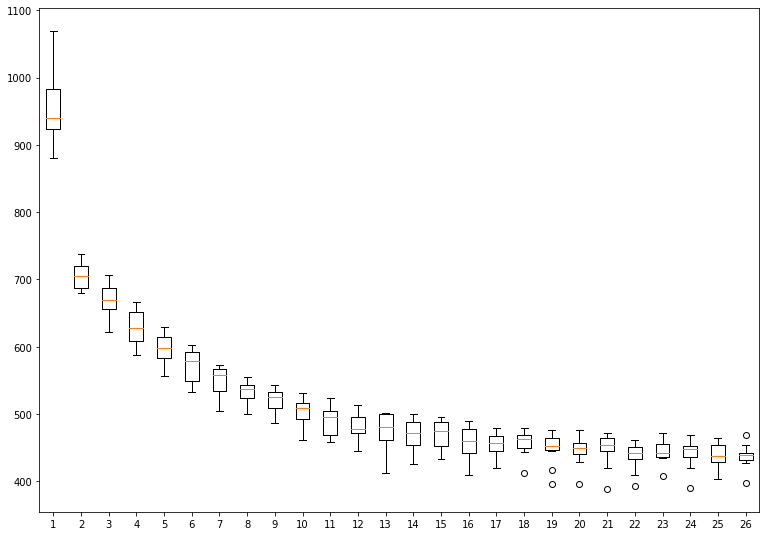

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


In [ ]:
runProblem()